## Time Series Forecasting with XGBoost

In [18]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./data/events_last_month_202411050944.csv')
df.head()

,v_bat,battery_soc,temperature,box_id,event_time
0,90.17,92.42,30.36,7832,2024-11-05 06:13:26
1,90.17,92.42,30.36,7832,2024-11-05 06:13:26
2,90.17,92.42,30.36,7832,2024-11-05 06:13:26
3,90.17,92.42,30.36,7832,2024-11-05 06:13:26
4,90.17,92.42,30.36,7832,2024-11-05 06:13:26


In [4]:
df['box_id'].unique()

array([7832, 5813, 9127, 4747, 2202, 9231, 9089])

In [5]:
dfs = {box_id: group for box_id, group in df.groupby('box_id')}

In [6]:
df_7832 = dfs[7832]
df_7832.head()

,v_bat,battery_soc,temperature,box_id,event_time
0,90.17,92.42,30.36,7832,2024-11-05 06:13:26
1,90.17,92.42,30.36,7832,2024-11-05 06:13:26
2,90.17,92.42,30.36,7832,2024-11-05 06:13:26
3,90.17,92.42,30.36,7832,2024-11-05 06:13:26
4,90.17,92.42,30.36,7832,2024-11-05 06:13:26


In [7]:
df_7832.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1651 entries, 0 to 10776
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   v_bat        1651 non-null   float64
 1   battery_soc  1651 non-null   float64
 2   temperature  1651 non-null   float64
 3   box_id       1651 non-null   int64  
 4   event_time   1651 non-null   object 
dtypes: float64(3), int64(1), object(1)
memory usage: 77.4+ KB


In [8]:
df_7832.describe()

,v_bat,battery_soc,temperature,box_id
count,1651.000000,1651.000000,1651.000000,1651.0
mean,91.688031,93.161114,33.882538,7832.0
std,3.258321,3.073220,2.534515,0.0
min,87.580000,87.740000,30.360000,7832.0
25%,89.420000,90.780000,31.640000,7832.0
50%,90.580000,93.070000,33.260000,7832.0
75%,92.670000,95.300000,35.550000,7832.0
max,98.170000,99.620000,40.380000,7832.0


In [9]:
def calculate_vol(v_bat):
    return (((v_bat/100) * 1200) + 3000)/1000

def calculate_soc(Vnormalized):
    return 112 - 112/(1 + ((1.9*Vnormalized)**2.9))

def calculate_soc_2(Vnormalized):
    return 270 - 270/((1 + ((3.5 * Vnormalized)**8))**0.045)

def normalize(voltage):
    return (voltage - min_vol) / (max_vol - min_vol)

max_vol = 4.2
min_vol = 3

df_7832 = (df_7832
      .assign(vol=lambda x: x['v_bat'].apply(calculate_vol))
      .assign(Vnormalized=lambda x: x['vol'].apply(normalize))
      .assign(soc=lambda x: x['Vnormalized'].apply(calculate_soc))
      .assign(soc_2=lambda x: x['Vnormalized'].apply(calculate_soc_2)))
df_7832.head()

,v_bat,battery_soc,temperature,box_id,event_time,vol,Vnormalized,soc,soc_2
0,90.17,92.42,30.36,7832,2024-11-05 06:13:26,4.08204,0.9017,92.572514,91.484908
1,90.17,92.42,30.36,7832,2024-11-05 06:13:26,4.08204,0.9017,92.572514,91.484908
2,90.17,92.42,30.36,7832,2024-11-05 06:13:26,4.08204,0.9017,92.572514,91.484908
3,90.17,92.42,30.36,7832,2024-11-05 06:13:26,4.08204,0.9017,92.572514,91.484908
4,90.17,92.42,30.36,7832,2024-11-05 06:13:26,4.08204,0.9017,92.572514,91.484908


In [10]:
df_7832.head()

,v_bat,battery_soc,temperature,box_id,event_time,vol,Vnormalized,soc,soc_2
0,90.17,92.42,30.36,7832,2024-11-05 06:13:26,4.08204,0.9017,92.572514,91.484908
1,90.17,92.42,30.36,7832,2024-11-05 06:13:26,4.08204,0.9017,92.572514,91.484908
2,90.17,92.42,30.36,7832,2024-11-05 06:13:26,4.08204,0.9017,92.572514,91.484908
3,90.17,92.42,30.36,7832,2024-11-05 06:13:26,4.08204,0.9017,92.572514,91.484908
4,90.17,92.42,30.36,7832,2024-11-05 06:13:26,4.08204,0.9017,92.572514,91.484908


In [11]:
df_7832 = df_7832.set_index('event_time')
df_7832.head()

,v_bat,battery_soc,temperature,box_id,vol,Vnormalized,soc,soc_2
event_time,,,,,,,,
2024-11-05 06:13:26,90.17,92.42,30.36,7832,4.08204,0.9017,92.572514,91.484908
2024-11-05 06:13:26,90.17,92.42,30.36,7832,4.08204,0.9017,92.572514,91.484908
2024-11-05 06:13:26,90.17,92.42,30.36,7832,4.08204,0.9017,92.572514,91.484908
2024-11-05 06:13:26,90.17,92.42,30.36,7832,4.08204,0.9017,92.572514,91.484908
2024-11-05 06:13:26,90.17,92.42,30.36,7832,4.08204,0.9017,92.572514,91.484908


In [12]:
df_7832 = df_7832[['box_id', 'temperature', 'vol', 'battery_soc', 'soc', 'soc_2']]


In [13]:
df_7832.head()

,box_id,temperature,vol,battery_soc,soc,soc_2
event_time,,,,,,
2024-11-05 06:13:26,7832,30.36,4.08204,92.42,92.572514,91.484908
2024-11-05 06:13:26,7832,30.36,4.08204,92.42,92.572514,91.484908
2024-11-05 06:13:26,7832,30.36,4.08204,92.42,92.572514,91.484908
2024-11-05 06:13:26,7832,30.36,4.08204,92.42,92.572514,91.484908
2024-11-05 06:13:26,7832,30.36,4.08204,92.42,92.572514,91.484908


In [26]:
df_7832.index = pd.to_datetime(df_7832.index)
# df_7832.sort_values('event_time', ascending=)
df_7832.sort_index(inplace=True)
df_7832.head()

,box_id,temperature,vol,battery_soc,soc,soc_2
event_time,,,,,,
2024-11-05 00:00:08,7832,32.29,4.07496,92.15,92.264912,91.062570
2024-11-05 00:00:08,7832,32.29,4.07496,92.15,92.264912,91.062570
2024-11-05 00:01:12,7832,32.43,4.07304,92.04,92.180485,90.947386
2024-11-05 00:01:22,7832,32.43,4.07304,92.04,92.180485,90.947386
2024-11-05 00:01:22,7832,32.43,4.07304,92.04,92.180485,90.947386


In [15]:
df_7832.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1651 entries, 2024-11-05 06:13:26 to 2024-11-05 00:00:08
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   box_id       1651 non-null   int64  
 1   temperature  1651 non-null   float64
 2   vol          1651 non-null   float64
 3   battery_soc  1651 non-null   float64
 4   soc          1651 non-null   float64
 5   soc_2        1651 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 90.3 KB


In [16]:
df_7832.describe()

,box_id,temperature,vol,battery_soc,soc,soc_2
count,1651.0,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000
mean,7832.0,33.882538,4.100256,93.161114,93.257024,92.501083
std,0.0,2.534515,0.039100,3.073220,1.531235,2.221083
min,7832.0,30.360000,4.050960,87.740000,91.177694,89.602306
25%,7832.0,31.640000,4.073040,90.780000,92.180485,90.947386
50%,7832.0,33.260000,4.086960,93.070000,92.782866,91.776192
75%,7832.0,35.550000,4.112040,95.300000,93.813248,93.233658
max,7832.0,40.380000,4.178040,99.620000,96.218926,96.864591


In [32]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#cc444b', '#e89005'])

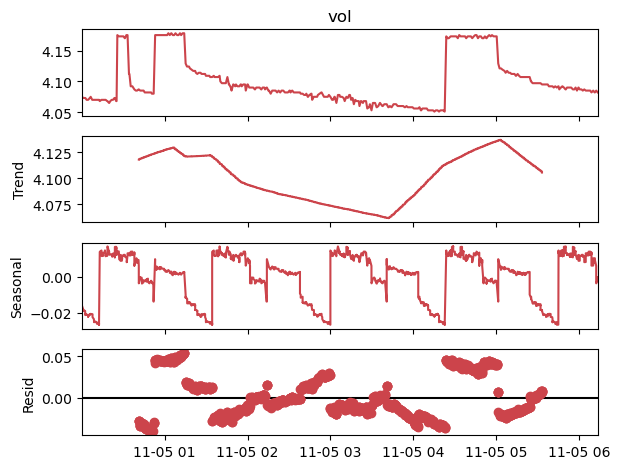

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df_7832['vol'], period=365).plot()
plt.show()

In [20]:
# df_7832.plot(figsize=(20,8))
# plt.title('Voltage', weight='bold', fontsize=25)

### Train / Test Split

In [35]:
df_train, df_test = df_7832[df_7832.index < '2024-11-05'], df_7832[df_7832.index >= '2024-11-05']

print('Train:\t', len(df_train))
print('Test:\t', len(df_test))

Train:	 0
Test:	 1651


In [39]:
plt.figure(figsize=(10,6))

df_train['vol'].plot(label='Training Set')
df_test['vol'].plot(label='Test Set')
plt.axvline('2024-11-05', color='black', ls='--', lw=3)
plt.text('2024-11-05', 3700, 'Split', fontsize=20, fontweight='bold')
plt.title('Data Splitting', weight='bold', fontsize=25)
plt.legend()

ValueError: Image size of 835x10787520 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x600 with 1 Axes>

### Building Models

#### 1. Time Series Cross Validation

### 3. Lag Features

What was the target (x) days in the past.


Retraining on all data

To Predict the future we need an emtpy dataframe for future date ranges.

Run those dates through our feature creation code + lag creation

### Predict the future